<a href="https://colab.research.google.com/github/maxkamenskiy/gamedev_analytics/blob/main/33_server_launch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import mysql.connector
from sqlalchemy import create_engine
from clickhouse_driver import Client

# Define the credentials and settings
host = 'INSERT'
user = 'userdb'
password = 'INSERT'
mysql_db = 'global'
clickhouse_db = 'analytics'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Donatelogs first five days

In [ ]:
clickhouse_client = Client(host=host, user=user, password=password, database=clickhouse_db)

dfs = []

for i in range(1, 34):
    try:
        table_name = f"analytics.{i:02d}_donatelogs"
        clickhouse_query = f"""
        SELECT created_date, count(distinct userGID) as users_count, sum(value)*-1 as value_sum
        FROM {table_name}
        WHERE value < 0
        GROUP BY created_date
        ORDER BY created_date ASC
        LIMIT 4;
        """
        clickhouse_data = clickhouse_client.execute(clickhouse_query)
        column_names = ['created_date', 'users_count', 'value_sum']
        clickhouse_df = pd.DataFrame(clickhouse_data, columns=column_names)


        server_name = f"server_{i:02d}"
        clickhouse_df['server_name'] = server_name

        dfs.append(clickhouse_df)
    except Exception as e:
        print(f"An error occurred with ClickHouse for table {table_name}: {e}")


final_df = pd.concat(dfs, ignore_index=True)

In [ ]:
final_df['rank'] = final_df.groupby('server_name')['created_date'].rank(method='dense').astype(int)

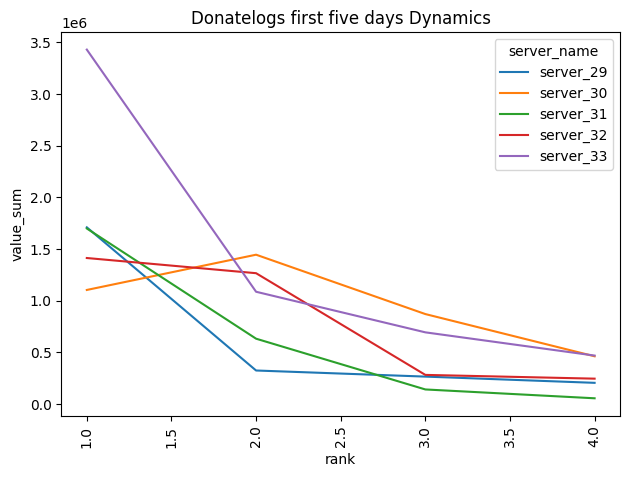

In [ ]:
sns.lineplot(data=final_df.loc[final_df['server_name']>='server_29'], x='rank', y='value_sum', hue='server_name')
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Donatelogs first five days Dynamics')
plt.show()

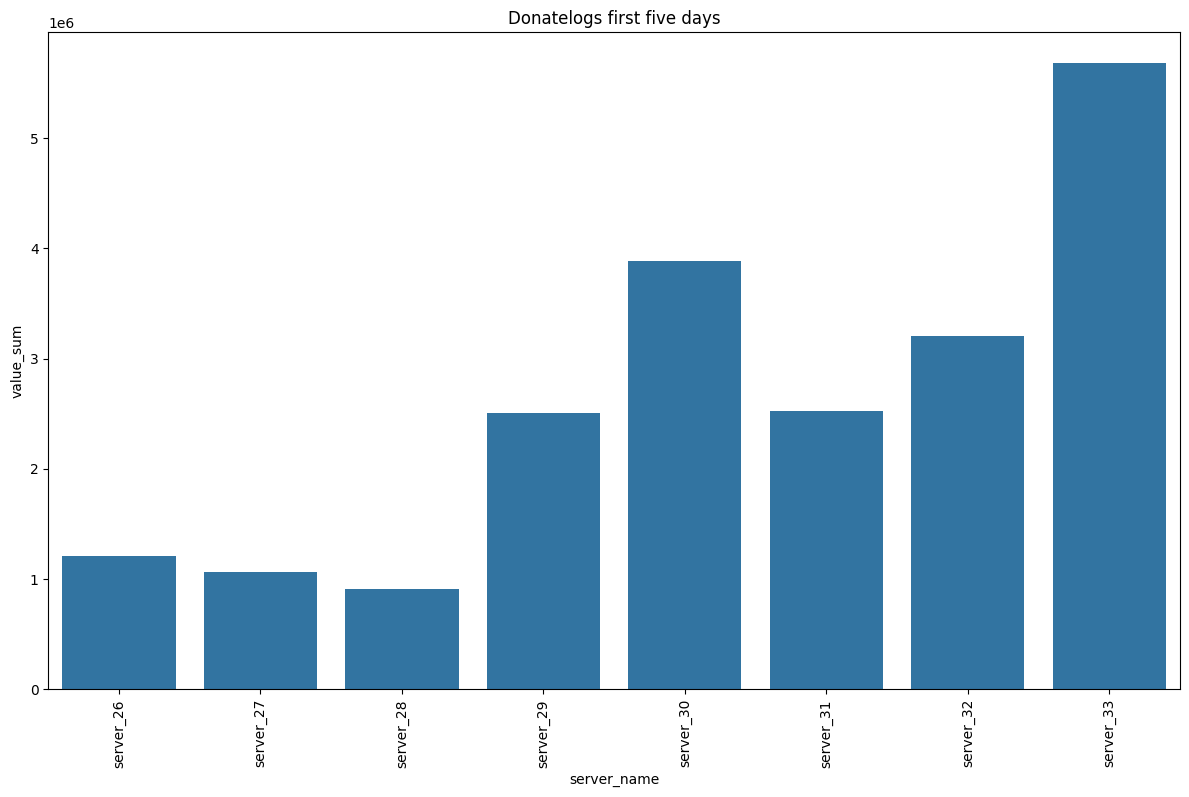

In [ ]:
grouped_df_donatelogs = final_df.loc[final_df['server_name']>='server_26'].groupby('server_name')['value_sum'].sum().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(data=grouped_df_donatelogs, y='value_sum', x='server_name',)
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Donatelogs first five days')
plt.show()

# Moneylogs first five days

In [ ]:
dfs = []


for i in range(1, 34):
    try:
        table_name = f"analytics.{i:02d}_moneylogs"
        clickhouse_query = f"""
        SELECT created_date, count(distinct senderGID) as users_count, sum(value)*-1 as value_sum
        FROM {table_name}
        WHERE value < 0
        and action not in ('Снятие денег с личного счёта (банк)', 'Пополнение личного счёта с банка', 'Обмен имуществом между игроками')
        GROUP BY created_date
        ORDER BY created_date ASC
        LIMIT 5;
        """
        clickhouse_data = clickhouse_client.execute(clickhouse_query)
        column_names = ['created_date', 'users_count', 'value_sum']
        clickhouse_df = pd.DataFrame(clickhouse_data, columns=column_names)


        server_name = f"server_{i:02d}"
        clickhouse_df['server_name'] = server_name

        dfs.append(clickhouse_df)
    except Exception as e:
        print(f"An error occurred with ClickHouse for table {table_name}: {e}")


final_df_moneylogs = pd.concat(dfs, ignore_index=True)

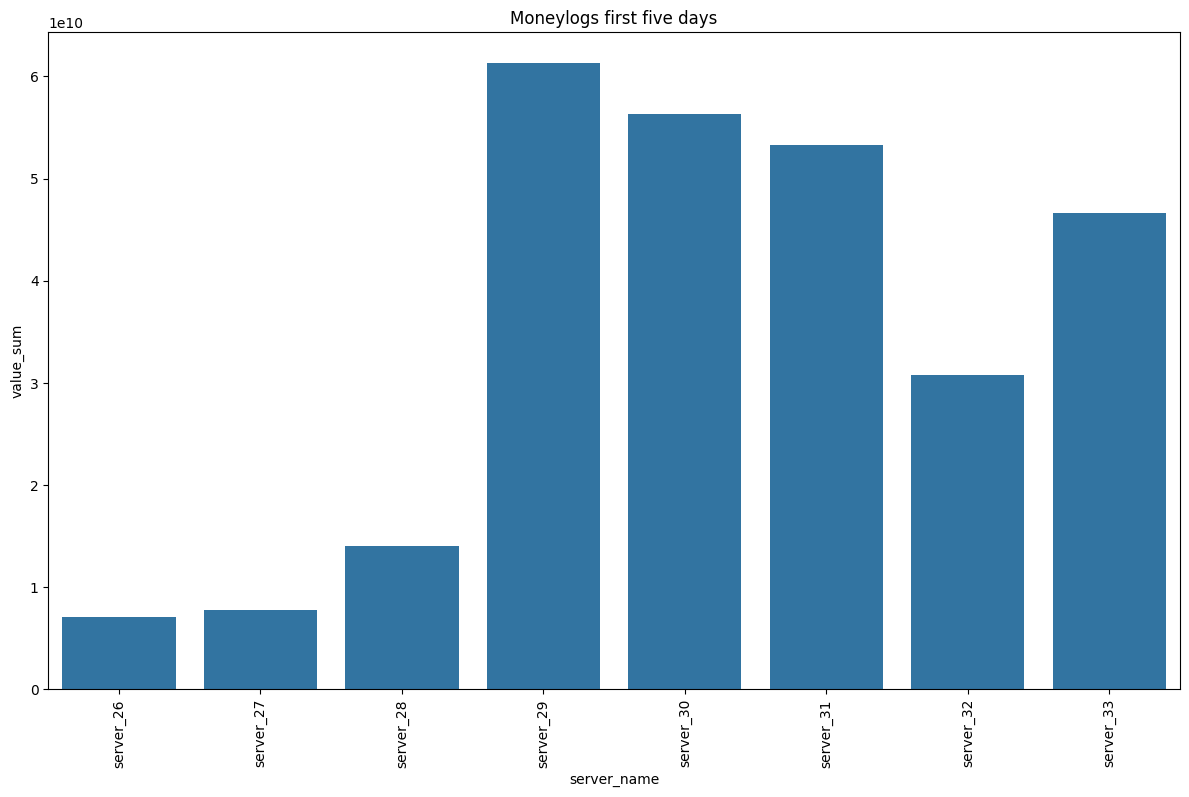

In [ ]:
grouped_df_moneylogs = final_df_moneylogs.loc[final_df_moneylogs['server_name']>='server_26'].groupby('server_name')['value_sum'].sum().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(data=grouped_df_moneylogs, y='value_sum', x='server_name',)
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Moneylogs first five days')
plt.show()

# Donatelogs per User per Day first five days

In [ ]:
dfs = []


for i in range(1, 34):
    try:
        table_name = f"analytics.{i:02d}_donatelogs"
        clickhouse_query = f"""
        WITH earliest_dates AS (
            SELECT created_date
            FROM {table_name}
            WHERE value < 0
            GROUP BY created_date
            ORDER BY created_date ASC
            LIMIT 5
        )
        SELECT (sum(value)*-1/count(distinct userGID))/count(distinct created_date) as avg_value_per_user
        FROM {table_name}
        WHERE created_date IN (SELECT created_date FROM earliest_dates) AND value < 0
        """
        clickhouse_data = clickhouse_client.execute(clickhouse_query)
        column_names = ['avg_value_per_user']
        clickhouse_df = pd.DataFrame(clickhouse_data, columns=column_names)


        server_name = f"server_{i:02d}"
        clickhouse_df['server_name'] = server_name

        dfs.append(clickhouse_df)
    except Exception as e:
        print(f"An error occurred with ClickHouse for table {table_name}: {e}")


final_df3 = pd.concat(dfs, ignore_index=True)

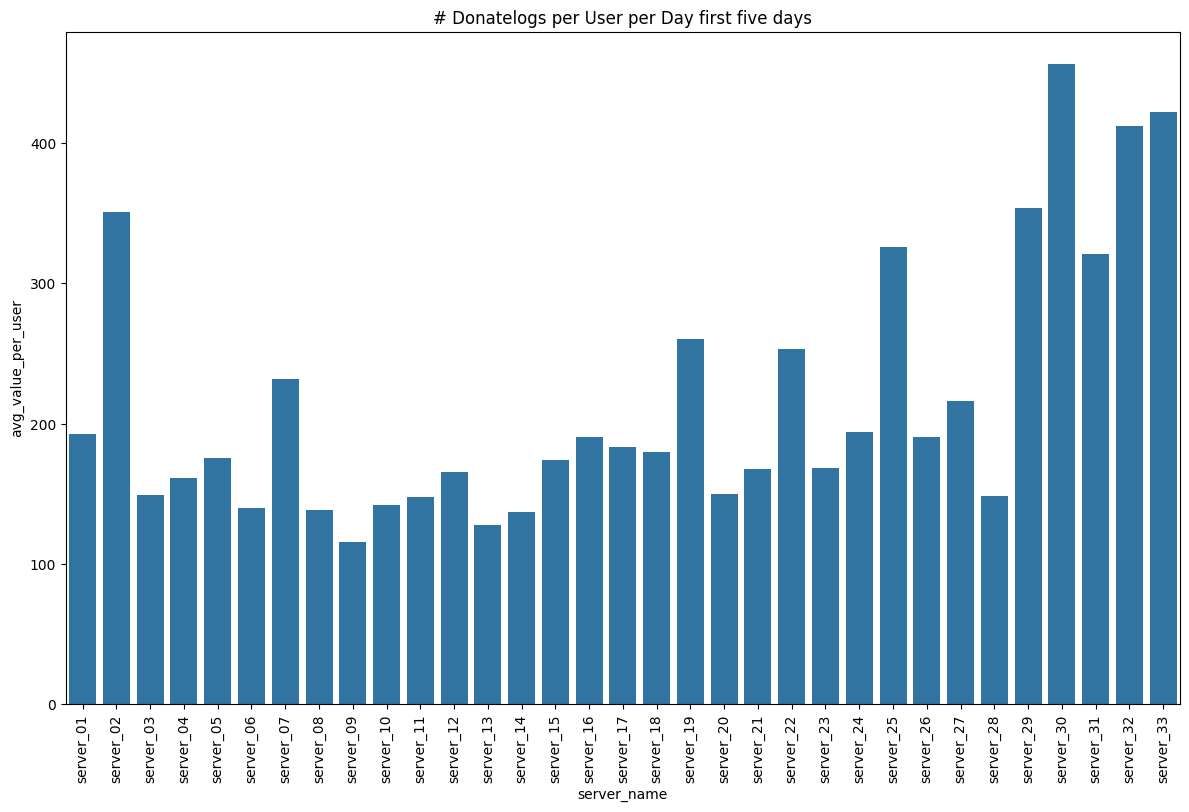

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(data=final_df3, y='avg_value_per_user', x='server_name',)
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Donatelogs per User per Day first five days')
plt.show()

# Distinct users first five days

In [ ]:
dfs = []


for i in range(1, 34):
    try:
        table_name = f"analytics.{i:02d}_donatelogs"
        clickhouse_query = f"""
        WITH earliest_dates AS (
            SELECT created_date
            FROM {table_name}
            WHERE value < 0
            GROUP BY created_date
            ORDER BY created_date ASC
            LIMIT 5
        )
        SELECT count(distinct userGID) as users_count
        FROM {table_name}
        WHERE created_date IN (SELECT created_date FROM earliest_dates) AND value < 0
        """
        clickhouse_data = clickhouse_client.execute(clickhouse_query)
        column_names = ['users_count']
        clickhouse_df = pd.DataFrame(clickhouse_data, columns=column_names)


        server_name = f"server_{i:02d}"
        clickhouse_df['server_name'] = server_name

        dfs.append(clickhouse_df)
    except Exception as e:
        print(f"An error occurred with ClickHouse for table {table_name}: {e}")


final_df4 = pd.concat(dfs, ignore_index=True)

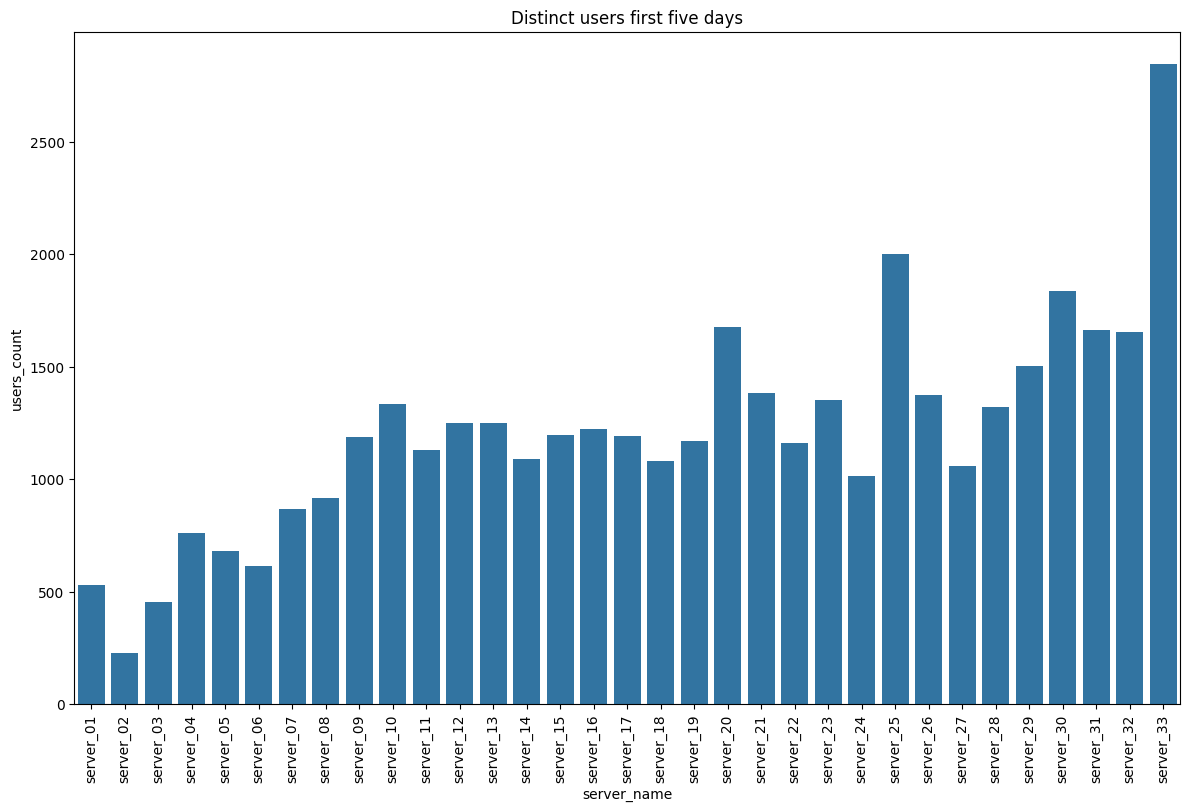

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(data=final_df4, y='users_count', x='server_name',)
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Distinct users first five days')
plt.show()

# Other analysis

In [ ]:
try:
    clickhouse_client = Client(host=host, user=user, password=password, database=clickhouse_db)
    clickhouse_query = "SELECT * FROM analytics.33_donatelogs order by created_date LIMIT 10;"  # SQL query adjusted for ClickHouse syntax
    clickhouse_data = clickhouse_client.execute(clickhouse_query)
    # Extract column names from DESCRIBE TABLE query and use them in DataFrame
    column_names_query = "DESCRIBE TABLE analytics.33_donatelogs"
    column_names = [col[0] for col in clickhouse_client.execute(column_names_query)]
    clickhouse_df = pd.DataFrame(clickhouse_data, columns=column_names)
except Exception as e:
    print(f"An error occurred with ClickHouse: {e}")

clickhouse_df.head()

,id,userGID,userID,userName,value,old,new,action,created_time,created_date
0,b8310c29-e3df-4238-8b56-8869c944d0fa,5354593,4034,Simyon_Simyonych,-139,995,856,Открытие кейса|Кейс RR Phantom|1,2024-05-19 20:26:37,2024-05-19
1,3f5ece7e-0750-4370-8b56-ed1bc9986bbc,3404838,1115,Andrey_Faster,-5,100,95,Конвертация коинов в игровую валюту (донат),2024-05-19 19:32:26,2024-05-19
2,fe0a87b7-4bd0-4022-8b56-fbd49c20a970,4654696,5188,Alex_Kataev,-95,5096,5001,Открытие кейса|Кейс фестиваля|1,2024-05-19 21:31:40,2024-05-19
3,4bbd02ca-3bac-42ef-8b6a-36d0d8a002d0,12223,3491,Axmed_Wengalbi,-31,31,0,Конвертация коинов в игровую валюту (донат),2024-05-19 19:21:33,2024-05-19
4,a469fcb4-dc2e-4ae4-8b59-6c2931efa9de,8658361,1992,Pablo_Escobare,-10,400,390,Конвертация коинов в игровую валюту (донат),2024-05-19 18:25:44,2024-05-19


In [ ]:
try:
    clickhouse_client = Client(host=host, user=user, password=password, database=clickhouse_db)
    clickhouse_query = "SELECT id, action, abs(value), value, is_bank, old, new, created_time FROM analytics.33_moneylogs where senderGID=5392298 order by abs(value) desc;"  # SQL query adjusted for ClickHouse syntax
    clickhouse_data = clickhouse_client.execute(clickhouse_query)
    # Extract column names from DESCRIBE TABLE query and use them in DataFrame
    #column_names_query = "DESCRIBE TABLE analytics.33_moneylogs"
    #column_names = [col[0] for col in clickhouse_client.execute(column_names_query)]
    column_names = ['id', 'action', 'abs_value', 'value', 'is_bank', 'old', 'new', 'created_time']
    clickhouse_df2 = pd.DataFrame(clickhouse_data, columns=column_names)
except Exception as e:
    print(f"An error occurred with ClickHouse: {e}")

clickhouse_df2

,id,action,abs_value,value,is_bank,old,new,created_time
0,587d25e1-6eec-49fc-8ec4-3baf353344b6,Пополнение личного счёта с банка,11000000,-11000000,0,11097280,97280,2024-05-20 00:19:00
1,6ccab41a-c546-43eb-b75f-feb152b853d7,Пополнение личного счёта с банка,11000000,11000000,1,0,11000000,2024-05-20 00:19:00
2,327185c8-73ad-456d-8d02-964a584d7f07,Ставка на дом 256,10100000,-10100000,1,11000000,900000,2024-05-20 00:20:46
3,df1816ea-8756-419d-85d4-52784074485f,Пополнение личного счёта с банка,4800000,4800000,1,0,4800000,2024-05-19 23:16:18
4,9b68e465-48c4-4fc6-8970-d80e29203789,Пополнение личного счёта с банка,4800000,-4800000,0,4813475,13475,2024-05-19 23:16:18
...,...,...,...,...,...,...,...,...
753,63fdf6a0-9640-402f-ba40-6e7ee9b90e48,Починка транспорта от механика,100,-100,0,1632880,1632780,2024-05-20 01:02:30
754,d55527cd-d83e-4685-bb26-2a52377faa9e,Починка транспорта от механика,100,-100,0,1633280,1633180,2024-05-20 01:02:07
755,11de4886-f7f5-43e0-bd71-085e0ae48a5d,Починка транспорта от механика,100,-100,0,1634180,1634080,2024-05-20 00:59:08
756,7e2aad2e-8f0e-4d32-be5b-1f1a37db47d2,Оплата за вход в бизнес,100,-100,0,9503150,9503050,2024-05-20 00:01:46


In [ ]:
try:
    clickhouse_client = Client(host=host, user=user, password=password, database=clickhouse_db)
    clickhouse_query = "SELECT action, sum(value) FROM analytics.33_moneylogs where action not like 'Передача денег%' group by action order by sum(value) desc;"  # SQL query adjusted for ClickHouse syntax
    clickhouse_data = clickhouse_client.execute(clickhouse_query)
    # Extract column names from DESCRIBE TABLE query and use them in DataFrame
    #column_names_query = "DESCRIBE TABLE analytics.33_moneylogs"
    column_names = ['action', 'sum_value']
    clickhouse_df2 = pd.DataFrame(clickhouse_data, columns=column_names)
except Exception as e:
    print(f"An error occurred with ClickHouse: {e}")

clickhouse_df2

,action,sum_value
0,Возврат ставки с дома 0,5256636961
1,Выпадение с кейса,3696216964
2,Возврат ставки с бизнеса 24,3659000000
3,Продажа машины Mercedes-Benz EQS 580 в гос,2478000000
4,Возврат ставки с бизнеса 35,2118020000
...,...,...
17689,Ставка на бизнес 55,-1107000123
17690,Ставка на бизнес 3,-1345138512
17691,Ставка на бизнес 35,-2837020000
17692,Покупка фишек,-3065840300


In [ ]:
clickhouse_df2.to_csv('actions_33_moneylogs.csv')